In [569]:
import os
import pandas
import numpy
from matplotlib import pyplot as plt
import matplotlib 

In [602]:
DATA_PATH = os.path.join("..", "data")
BNN_FILE = os.path.join(DATA_PATH, "GermanyKreisebene_Risklayer_bnn-20200425.csv")
TS_FILE =  os.path.join(DATA_PATH, "GermanyValues_RiskLayer-20200425.csv")
PICS_PATH = os.path.join(DATA_PATH, "..", "pics")
PAGES_PATH = os.path.join(DATA_PATH, "..", "pages")

In [684]:
def load_data(ts_f=TS_FILE, bnn_f=BNN_FILE):
    ts=pandas.read_csv(ts_f)
    bnn=pandas.read_csv(bnn_f)
    return ts, bnn
ts, bnn = load_data()

synthetic_data = [0]*10 + [20,80,100] + [100] * (len(ts.columns)-2-10-3)
row = pandas.Series(["00000", "Dummykreis"]+synthetic_data, index=ts.columns)
ts=ts.append(row, ignore_index=True)

synthetic_landkreis = [0, "Dummykreis", "Landkreis", 150000, 100, 0.67, 0, 300,"Dummyland", 400000, 0.75]
row = pandas.Series(synthetic_landkreis, index=bnn.columns)
bnn=bnn.append(row, ignore_index=True)

In [378]:
bnn

,AGS,GEN,BEZ,Population,Infections,Infections per 1000 population,AGS_number,Infections_Bundesland,Bundesland,Population_Bundesland,Infections_Bundesland per 1000 population
0,1051,Dithmarschen,Kreis,133210,54,"0,41",1051,2626,Schleswig-Holstein,2896712,"0,91"
1,1001,Flensburg,Kreisfreie Stadt,89504,32,"0,36",1001,2626,Schleswig-Holstein,2896712,"0,91"
2,1053,Herzogtum Lauenburg,Kreis,197264,255,"1,29",1053,2626,Schleswig-Holstein,2896712,"0,91"
3,1002,Kiel,Kreisfreie Stadt,247548,248,"1,00",1002,2626,Schleswig-Holstein,2896712,"0,91"
4,1003,Lübeck,Kreisfreie Stadt,217198,159,"0,73",1003,2626,Schleswig-Holstein,2896712,"0,91"
...,...,...,...,...,...,...,...,...,...,...,...
397,16064,Unstrut-Hainich-Kreis,Landkreis,102912,70,"0,68",16064,2091,Thüringen,2143145,"0,98"
398,16063,Wartburgkreis,Landkreis,123025,38,"0,31",16063,2091,Thüringen,2143145,"0,98"
399,16055,Weimar,Kreisfreie Stadt,65090,60,"0,92",16055,2091,Thüringen,2143145,"0,98"
400,16071,Weimarer Land,Landkreis,81947,67,"0,82",16071,2091,Thüringen,2143145,"0,98"


In [309]:
def find_AGS(name):
    cond = ts['ADMIN'].str.contains(name, na=False)
    # return cond
    rows = ts.loc[cond]
    return rows
find_AGS("Osnabrück")
find_AGS("Heinsberg")


,AGS,ADMIN,05.03.2020,06.03.2020,07.03.2020,08.03.2020,09.03.2020,10.03.2020,11.03.2020,12.03.2020,...,16.04.2020,17.04.2020,18.04.2020,19.04.2020,20.04.2020,21.04.2020,22.04.2020,23.04.2020,24.04.2020,25.04.2020
142,05370,Heinsberg (Kreis),114.0,197.0,214.0,283.0,300.0,323.0,365.0,403.0,...,1610.0,1620.0,1635.0,1635.0,1684.0,1698.0,1707.0,1711.0,1718.0,1718.0


In [310]:
import datetime as dt
def to_dt(dt_str):
    d = list(map(int, dt_str.split(".")))
    # print(d)
    return dt.datetime(d[2], d[1], d[0])

dates=[to_dt(d) for d in ts.columns[2:].values]
print (dates)
# ts.values[0]

[datetime.datetime(2020, 3, 5, 0, 0), datetime.datetime(2020, 3, 6, 0, 0), datetime.datetime(2020, 3, 7, 0, 0), datetime.datetime(2020, 3, 8, 0, 0), datetime.datetime(2020, 3, 9, 0, 0), datetime.datetime(2020, 3, 10, 0, 0), datetime.datetime(2020, 3, 11, 0, 0), datetime.datetime(2020, 3, 12, 0, 0), datetime.datetime(2020, 3, 13, 0, 0), datetime.datetime(2020, 3, 14, 0, 0), datetime.datetime(2020, 3, 15, 0, 0), datetime.datetime(2020, 3, 16, 0, 0), datetime.datetime(2020, 3, 17, 0, 0), datetime.datetime(2020, 3, 18, 0, 0), datetime.datetime(2020, 3, 19, 0, 0), datetime.datetime(2020, 3, 20, 0, 0), datetime.datetime(2020, 3, 21, 0, 0), datetime.datetime(2020, 3, 22, 0, 0), datetime.datetime(2020, 3, 23, 0, 0), datetime.datetime(2020, 3, 24, 0, 0), datetime.datetime(2020, 3, 25, 0, 0), datetime.datetime(2020, 3, 26, 0, 0), datetime.datetime(2020, 3, 27, 0, 0), datetime.datetime(2020, 3, 28, 0, 0), datetime.datetime(2020, 3, 29, 0, 0), datetime.datetime(2020, 3, 30, 0, 0), datetime.datetim

In [315]:
def AGS_to_ts_total(AGS):
    AGS = ("00000"+AGS)[-5:]
    row = ts.loc[ts['AGS'] == AGS]
    return row.values[0][2:].tolist()
    
AGS = "0"
AGS = "1001"
AGS_to_ts_total(AGS)

[0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 1.0,
 4.0,
 6.0,
 7.0,
 7.0,
 8.0,
 10.0,
 13.0,
 15.0,
 15.0,
 15.0,
 16.0,
 18.0,
 21.0,
 21.0,
 21.0,
 21.0,
 22.0,
 23.0,
 25.0,
 25.0,
 27.0,
 31.0,
 28.0,
 28.0,
 30.0,
 30.0,
 31.0,
 32.0,
 32.0,
 32.0,
 32.0,
 32.0,
 32.0,
 32.0,
 32.0,
 32.0,
 32.0,
 32.0,
 32.0,
 32.0,
 32.0,
 32.0]

In [318]:
def AGS_to_ts_daily(AGS):
    AGS = ("00000"+AGS)[-5:]
    row = ts.loc[ts['AGS'] == AGS]
    row = row.drop(['AGS', 'ADMIN'], axis=1)
    # return row
    diff = row.diff(axis=1)
    return diff.values[0].tolist()
    
AGS="0"
#AGS="5370"
print(AGS_to_ts_daily(AGS))

[nan, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 20.0, 60.0, 20.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


In [327]:
def AGS_to_population(AGS):
    # AGS = ("00000"+AGS)[-5:]
    AGS = int(AGS)
    # print(AGS)
    row = bnn.loc[bnn['AGS'] == AGS]
    pop = row["Population"].values[0] 
    inf = row["Infections"].values[0] 
    gen = row["GEN"].values[0] 
    bez = row["BEZ"].values[0] 
    return gen, bez, inf, pop
def AGS_to_Bundesland(AGS):
    # AGS = ("00000"+AGS)[-5:]
    AGS = int(AGS)
    row = bnn.loc[bnn['AGS'] == AGS]
    name = row["Bundesland"].values[0] 
    inf_BL = row["Infections_Bundesland"].values[0] 
    pop_BL = row["Population_Bundesland"].values[0] 
    return name, inf_BL, pop_BL

AGS="0"
#AGS="1001"
print (AGS_to_population(AGS)) 
print(AGS_to_Bundesland(AGS))

('Dummykreis', 'Landkreis', 100, 150000)
('Dummyland', 300, 400000)


In [367]:
def temporal_center(data):
    """
    find 'center' index of data by 
    multiplying height with index, and dividing by sum of heights
    
    TODO: what to do with the negative values?
          Cut them out before summing perhaps?
          On the other hand, they (temporarily-)LOCALLY correct over-reported cases, right?
          So perhaps better to leave them in?
    """
    ddata = data[1:] # drop the nan in the first cell, i.e. shift left
    productsum = sum([d*(i+1) for i,d in enumerate(ddata)]) # add one i.e. shift right
    center = productsum/sum(ddata) # + 1 - 1 # shift left and right equalize each other
    # synthetic "data" with one peak near center:
    signal = [0]*len(data)
    signal[int(round(center))]=max(ddata)*0.25
    return center, signal
    
data = AGS_to_ts_daily("00000")
# print (data)
center, signal = temporal_center(data)
print ("center at day %.2f" % center)
    

center at day 21.00


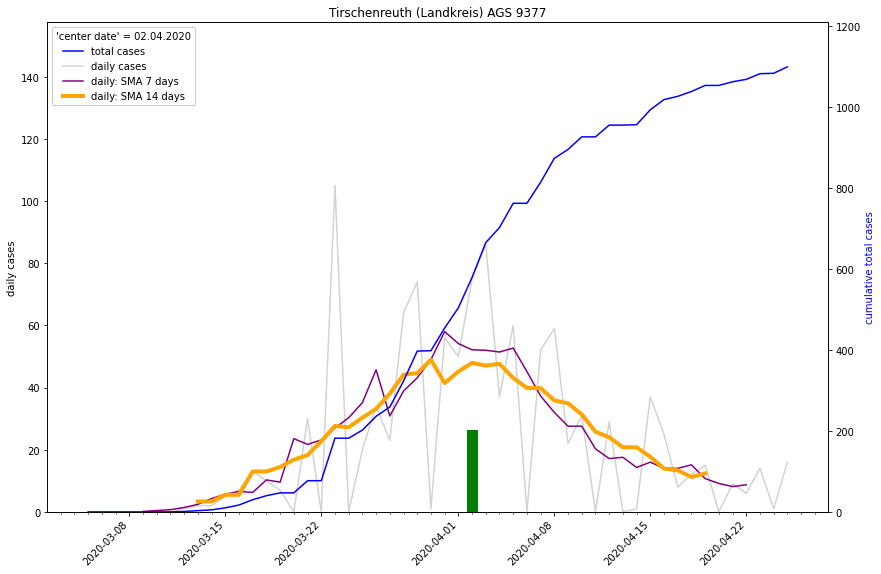

In [467]:
def plot_timeseries(dates, daily, cumulative, title, filename):

    fig, ax = plt.subplots(figsize=(14, 10)) #, constrained_layout=True)
    # plt.tight_layout()

    # x axis
    ax.xaxis_date()
    ax.xaxis.set_minor_locator(matplotlib.dates.DayLocator())
    fig.autofmt_xdate(rotation=45)


    # plot data
    lns1 = ax.plot(dates, daily, label="daily cases", color='lightgray')
    plt.ylabel("daily cases", color="black")
    plt.ylim(0, max(daily[1:])*1.5)

    # plot averages
    window=7
    rolling_mean = pandas.DataFrame(daily).rolling(window=window, center=True).mean()
    lns2 = ax.plot(dates, rolling_mean, label='daily: SMA %s days' % window, color='purple')

    window=14
    rolling_mean = pandas.DataFrame(daily).rolling(window=window, center=True).mean()
    lns3 = ax.plot(dates, rolling_mean, label='daily: SMA %s days' % window, color='orange', linewidth=4)

    # window=21
    # rolling_mean = pandas.DataFrame(daily).rolling(window=window, center=True).mean()
    # ax.plot(dates, rolling_mean, label='SMA %s days' % window, color='pink', linewidth=1)

    # plot center bar
    center, signal = temporal_center(daily)
    center_date=ts.columns[2:].values[int(round(center))]
    lns4 = ax.bar(dates, signal, label="'center day': "+center_date, color='green')
    # lns4 = ax.plot(dates, signal, label="'center day': "+center_date, color='green', kind='bar')


    # plot 2nd axis and cumulative data
    ax2 = plt.twinx()
    plt.ylim(0, max(cumulative)*1.1)
    plt.ylabel("cumulative total cases", color="b")

    lns5 = ax2.plot(dates, cumulative, label="total cases", color = 'b')

    lines = lns5 + lns1 + lns2 + lns3
    labs = [l.get_label() for l in lines]

    plt.legend(lines, labs, loc='best', facecolor="white", framealpha=1, 
               title="'center date' = "+center_date)

    plt.title(title)
    plt.show()
    
    fig.savefig(os.path.join(PICS_PATH, filename),  bbox_inches='tight')

    
def get_Kreis(AGS):
    # get data and names
    gen, bez, inf, pop = AGS_to_population(AGS)
    title = "%s (%s) AGS %s" % (gen, bez, AGS)
    filename = "Kreis_" + ("00000"+AGS)[-5:] + ".png"
    daily = AGS_to_ts_daily(AGS)
    cumulative = AGS_to_ts_total(AGS)
    return daily, cumulative, title, filename
# print (cumulative)

AGS = "00000"
# AGS = "5370"
AGS = "1001"
AGS="9377"

daily, cumulative, title, filename = get_Kreis(AGS)
plot_timeseries(dates, daily, cumulative, title, filename=filename)

In [499]:
import copy
ts_int = copy.deepcopy(ts.dropna()) # careful, there might be more fields with na but just the 3 copyright rows
ts_int["AGS"]=pandas.to_numeric(ts_int["AGS"]) # must transform string to int, for merge:
ts_BuLa=pandas.merge(ts_int, bnn[["AGS", "Bundesland", "Population"]], how="left", on=["AGS"])
ts_BuLa

,AGS,ADMIN,05.03.2020,06.03.2020,07.03.2020,08.03.2020,09.03.2020,10.03.2020,11.03.2020,12.03.2020,...,18.04.2020,19.04.2020,20.04.2020,21.04.2020,22.04.2020,23.04.2020,24.04.2020,25.04.2020,Bundesland,Population
0,7131,Ahrweiler (Landkreis),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,115.0,115.0,115.0,115.0,116.0,116.0,118.0,118.0,Rheinland-Pfalz,129727
1,9771,Aichach-Friedberg (Landkreis),1.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,...,259.0,262.0,262.0,272.0,273.0,278.0,278.0,283.0,Bayern,133596
2,8425,Alb-Donau-Kreis (Landkreis),2.0,2.0,2.0,3.0,3.0,3.0,3.0,6.0,...,475.0,481.0,495.0,489.0,501.0,514.0,526.0,533.0,Baden-Württemberg,196047
3,16077,Altenburger Land (Landkreis),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,41.0,41.0,41.0,45.0,45.0,45.0,47.0,47.0,Thüringen,90118
4,7132,Altenkirchen (Westerwald) (Landkreis),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,121.0,121.0,128.0,128.0,128.0,134.0,137.0,138.0,Rheinland-Pfalz,128705
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
397,9679,Würzburg (Landkreis),0.0,0.0,3.0,3.0,3.0,9.0,9.0,10.0,...,376.0,386.0,386.0,388.0,397.0,396.0,399.0,401.0,Bayern,161834
398,8417,Zollernalbkreis (Landkreis),2.0,10.0,11.0,11.0,11.0,11.0,15.0,19.0,...,828.0,840.0,874.0,887.0,892.0,930.0,961.0,981.0,Baden-Württemberg,188935
399,7320,Zweibrücken (Kreisfreie Stadt),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,37.0,37.0,37.0,37.0,37.0,37.0,37.0,37.0,Rheinland-Pfalz,34209
400,14524,Zwickau (Landkreis),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,690.0,693.0,697.0,707.0,709.0,717.0,724.0,730.0,Sachsen,317531


In [500]:
Bundeslaender=ts_BuLa.drop(["AGS"], axis=1).groupby(["Bundesland"]).sum()
print(Bundeslaender["Population"].sum())
Bundeslaender

83169213


,05.03.2020,06.03.2020,07.03.2020,08.03.2020,09.03.2020,10.03.2020,11.03.2020,12.03.2020,13.03.2020,14.03.2020,...,17.04.2020,18.04.2020,19.04.2020,20.04.2020,21.04.2020,22.04.2020,23.04.2020,24.04.2020,25.04.2020,Population
Bundesland,,,,,,,,,,,,,,,,,,,,,
Baden-Württemberg,65.0,91.0,116.0,182.0,199.0,234.0,279.0,367.0,560.0,816.0,...,28159.0,28791.0,29173.0,29664.0,29936.0,30202.0,30713.0,31213.0,31619.0,11069533
Bayern,70.0,91.0,119.0,149.0,203.0,262.0,330.0,379.0,517.0,675.0,...,36467.0,37419.0,37986.0,38453.0,38904.0,39340.0,39886.0,40491.0,41097.0,13076721
Berlin,9.0,15.0,19.0,28.0,40.0,48.0,58.0,90.0,137.0,174.0,...,4971.0,5091.0,5187.0,5225.0,5265.0,5341.0,5355.0,5476.0,5532.0,3644826
Brandenburg,1.0,1.0,2.0,2.0,2.0,7.0,16.0,24.0,29.0,45.0,...,2255.0,2311.0,2354.0,2401.0,2454.0,2477.0,2541.0,2653.0,2704.0,2511917
Bremen,3.0,3.0,4.0,4.0,4.0,4.0,22.0,32.0,42.0,48.0,...,553.0,564.0,582.0,601.0,607.0,625.0,673.0,708.0,720.0,682986
Dummyland,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,150000
Hamburg,5.0,6.0,11.0,13.0,17.0,22.0,35.0,54.0,88.0,123.0,...,4064.0,4195.0,4297.0,4347.0,4368.0,4401.0,4449.0,4511.0,4558.0,1841179
Hessen,12.0,12.0,14.0,14.0,14.0,28.0,38.0,50.0,105.0,166.0,...,6682.0,6900.0,7052.0,7183.0,7265.0,7395.0,7536.0,7732.0,7848.0,6265809
Mecklenburg-Vorpommern,4.0,5.0,5.0,6.0,8.0,10.0,14.0,17.0,23.0,33.0,...,642.0,644.0,650.0,652.0,655.0,656.0,659.0,661.0,667.0,1609675


In [502]:
#Bundeslaender.drop(["Population"], axis=1).loc['Hessen'].to_list()

In [503]:
def get_BuLa(name):
    # get data and names
    title = name
    filename = "bundesland_" + name + ".png"
    population = Bundeslaender.loc['Hessen', "Population"]
    # row = Bundeslaender.loc[Bundeslaender['Bundesland'] == name]
    row = Bundeslaender.drop(["Population"], axis=1).loc[[name]]
    
    cumulative=row.values[0].tolist()
    diff = row.diff(axis=1)
    daily = diff.values[0].tolist()
    
    return daily, cumulative, title, filename, population

daily, cumulative, title, filename, population = get_BuLa("Hessen")
[title, filename, population, daily, cumulative]


['Hessen',
 'bundesland_Hessen.png',
 6265809,
 [nan,
  0.0,
  2.0,
  0.0,
  0.0,
  14.0,
  10.0,
  12.0,
  55.0,
  61.0,
  64.0,
  88.0,
  70.0,
  109.0,
  157.0,
  246.0,
  258.0,
  169.0,
  148.0,
  127.0,
  203.0,
  227.0,
  300.0,
  255.0,
  330.0,
  195.0,
  139.0,
  210.0,
  308.0,
  319.0,
  228.0,
  214.0,
  129.0,
  154.0,
  198.0,
  262.0,
  268.0,
  268.0,
  169.0,
  123.0,
  92.0,
  98.0,
  197.0,
  194.0,
  218.0,
  152.0,
  131.0,
  82.0,
  130.0,
  141.0,
  196.0,
  116.0],
 [12.0,
  12.0,
  14.0,
  14.0,
  14.0,
  28.0,
  38.0,
  50.0,
  105.0,
  166.0,
  230.0,
  318.0,
  388.0,
  497.0,
  654.0,
  900.0,
  1158.0,
  1327.0,
  1475.0,
  1602.0,
  1805.0,
  2032.0,
  2332.0,
  2587.0,
  2917.0,
  3112.0,
  3251.0,
  3461.0,
  3769.0,
  4088.0,
  4316.0,
  4530.0,
  4659.0,
  4813.0,
  5011.0,
  5273.0,
  5541.0,
  5809.0,
  5978.0,
  6101.0,
  6193.0,
  6291.0,
  6488.0,
  6682.0,
  6900.0,
  7052.0,
  7183.0,
  7265.0,
  7395.0,
  7536.0,
  7732.0,
  7848.0]]

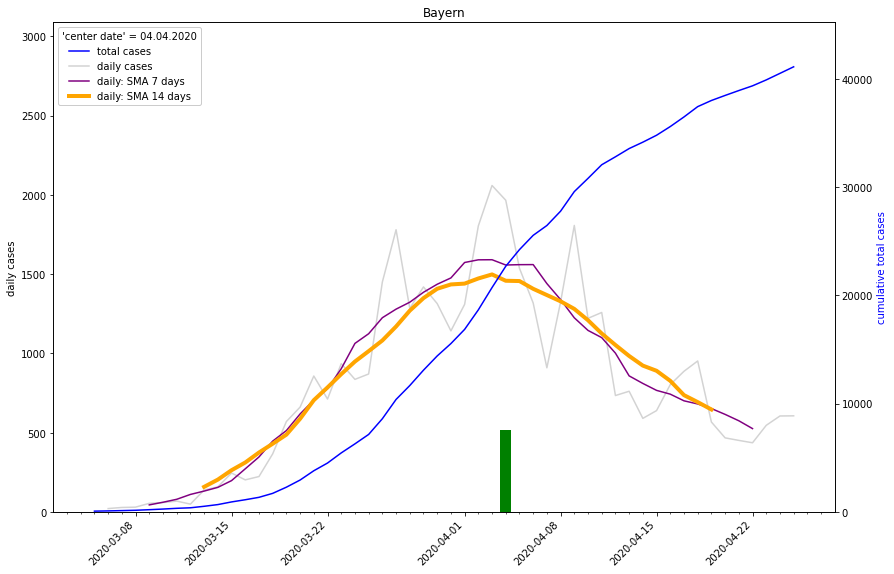

In [472]:
daily, cumulative, title, filename, population = get_BuLa("Bayern")
plot_timeseries(dates, daily, cumulative, title, filename=filename)

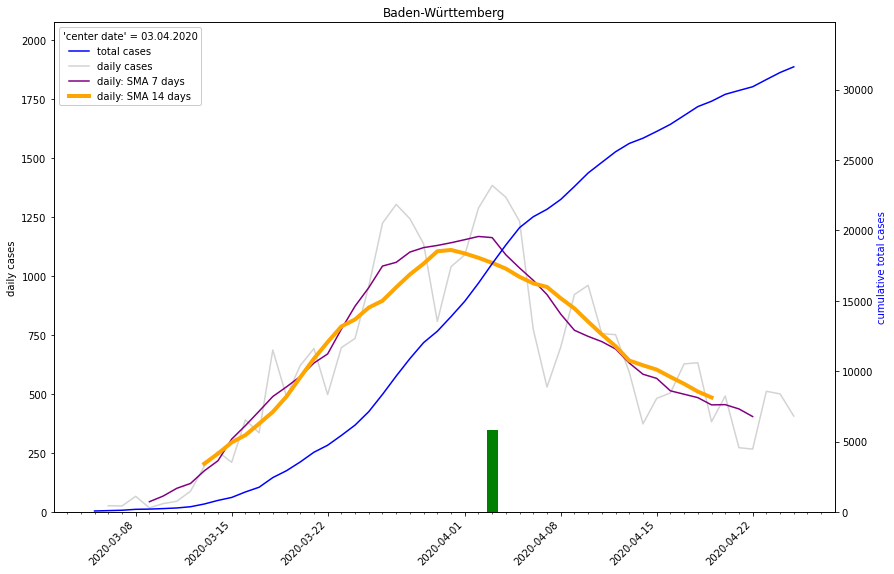

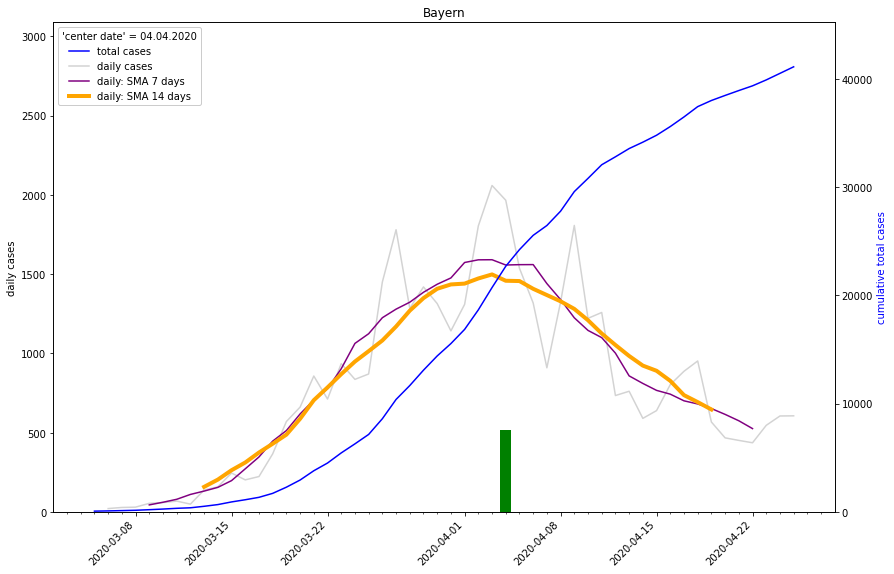

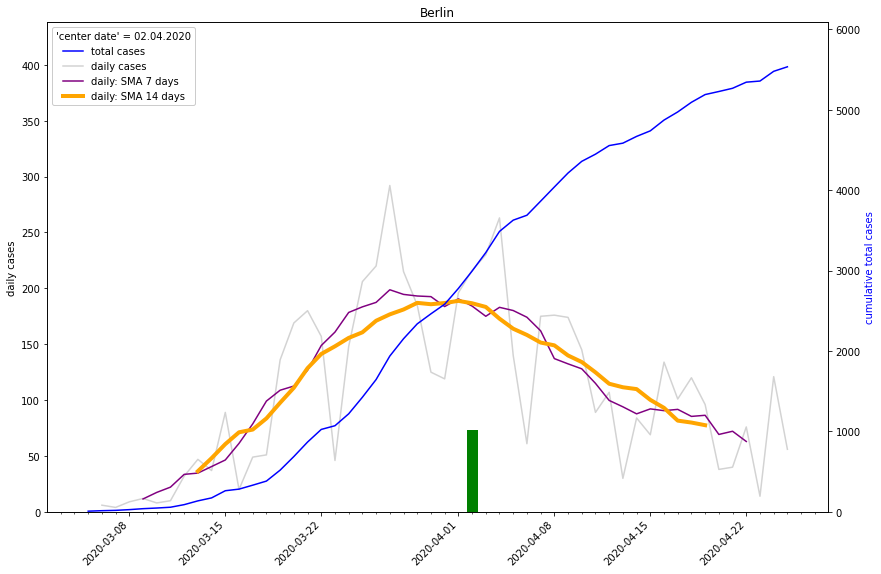

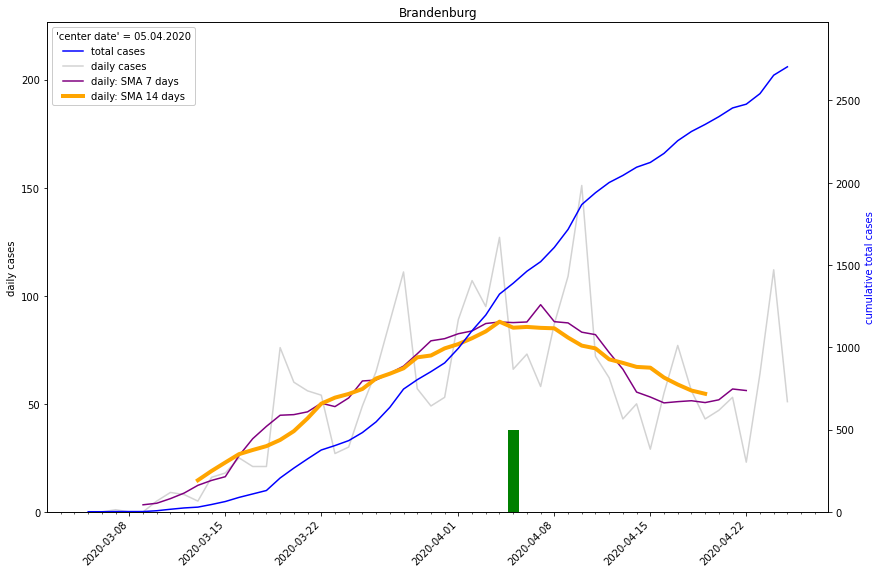

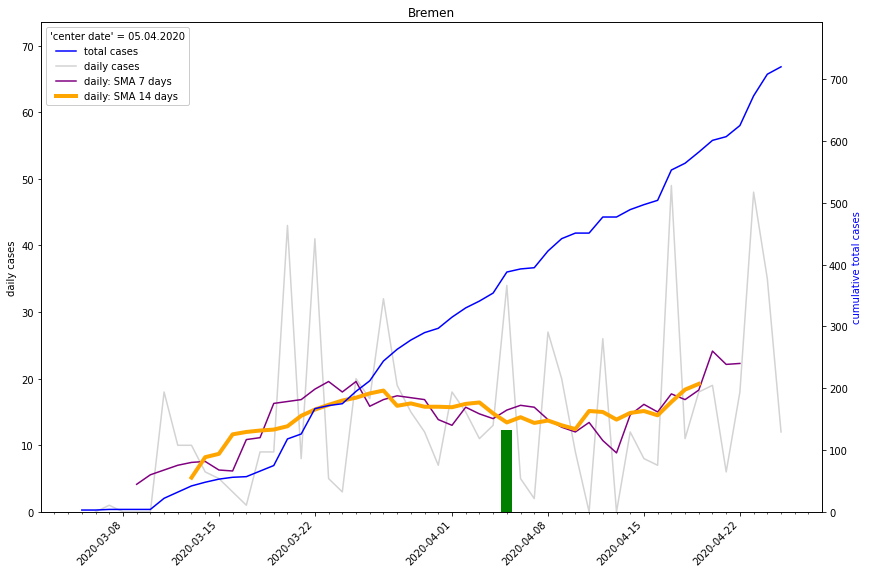

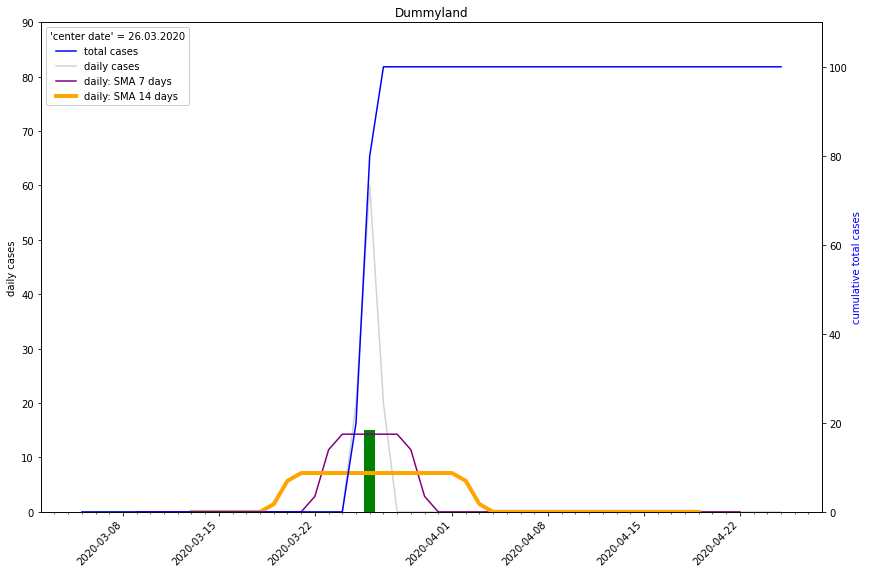

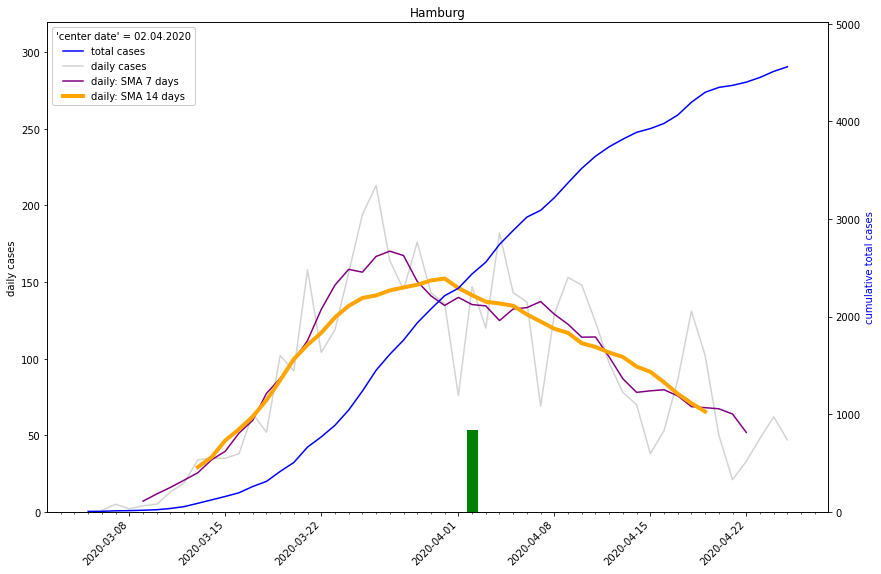

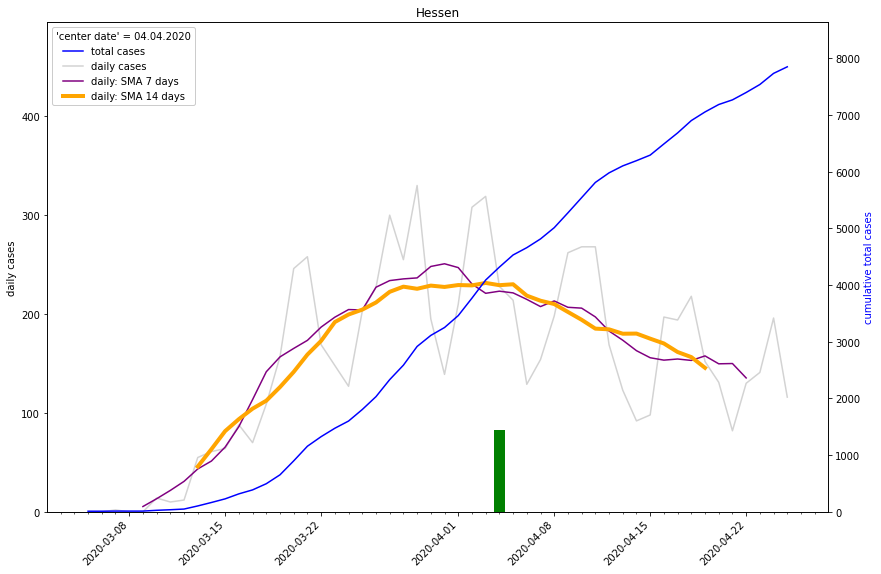

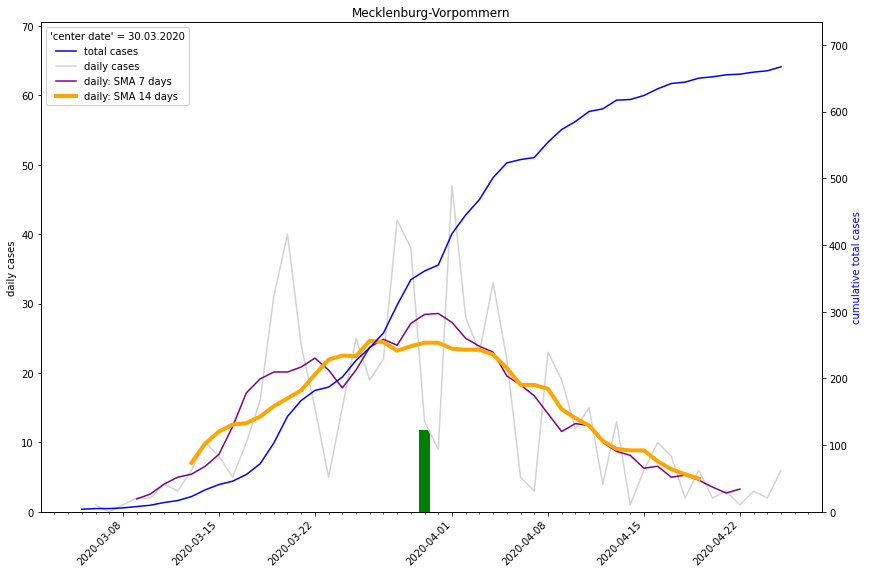

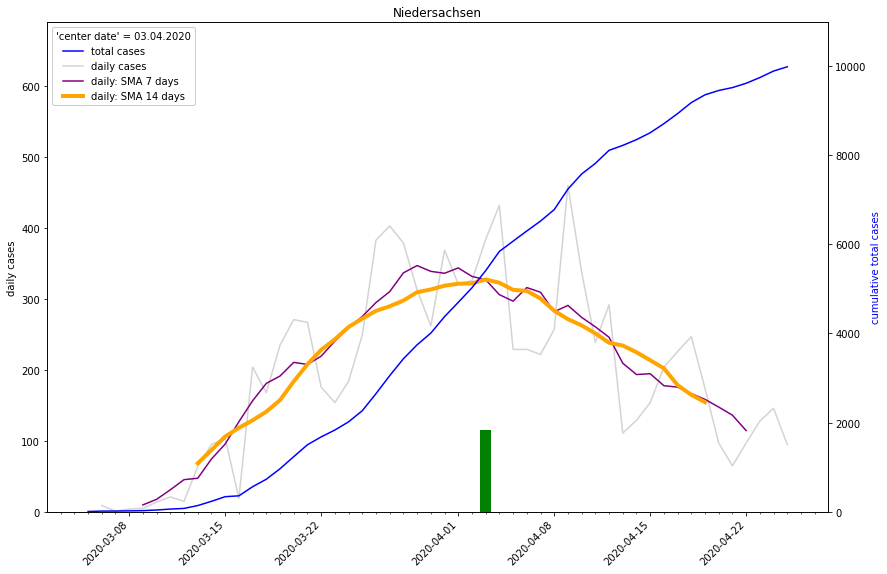

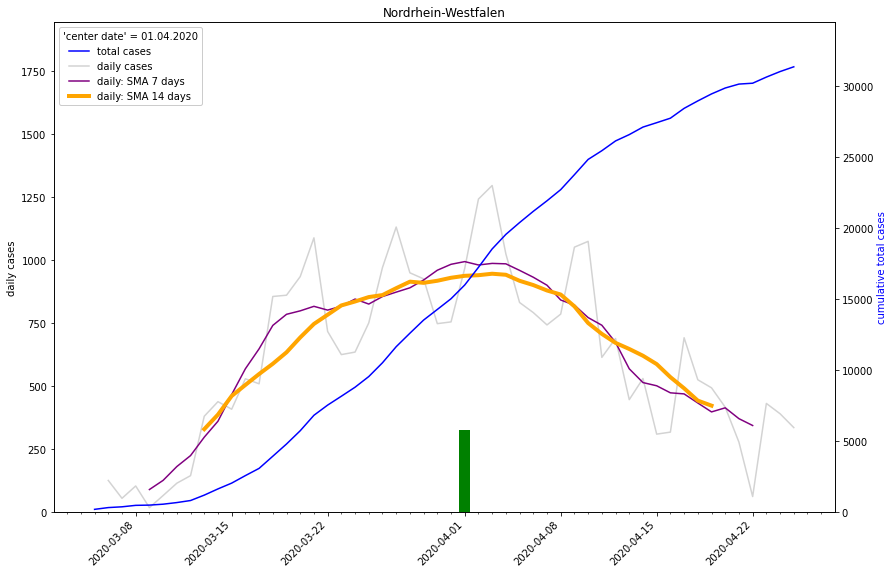

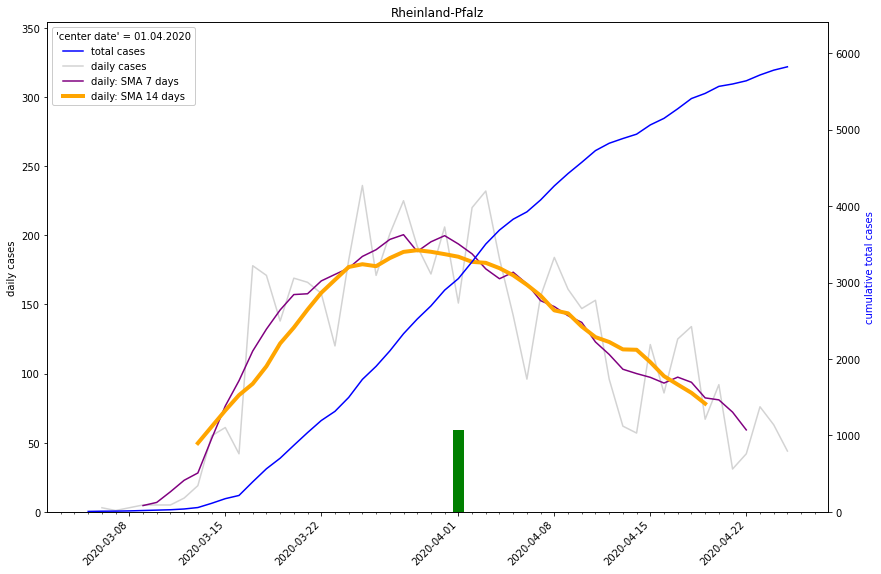

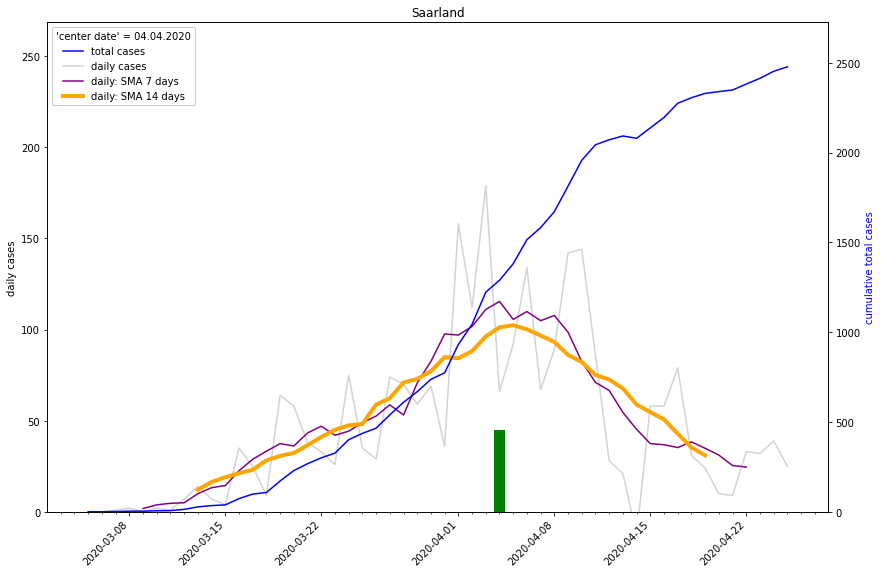

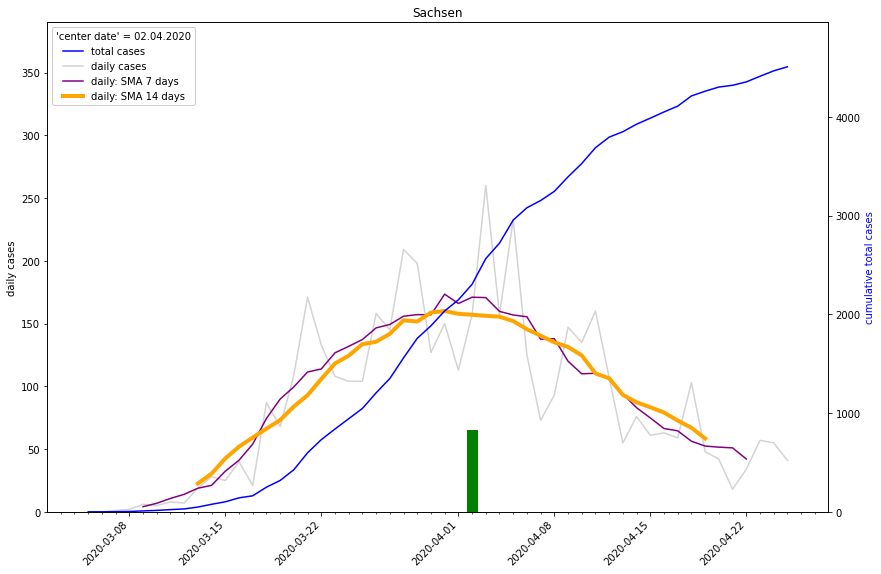

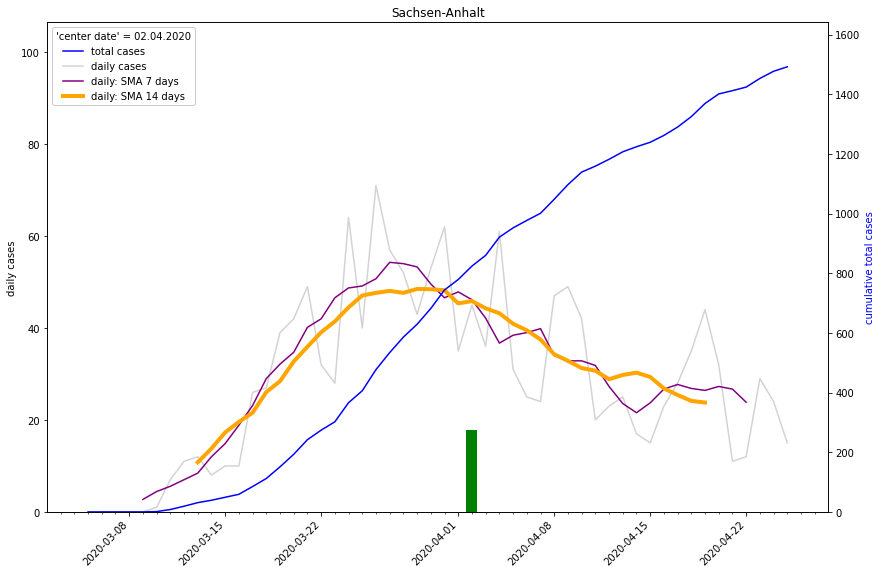

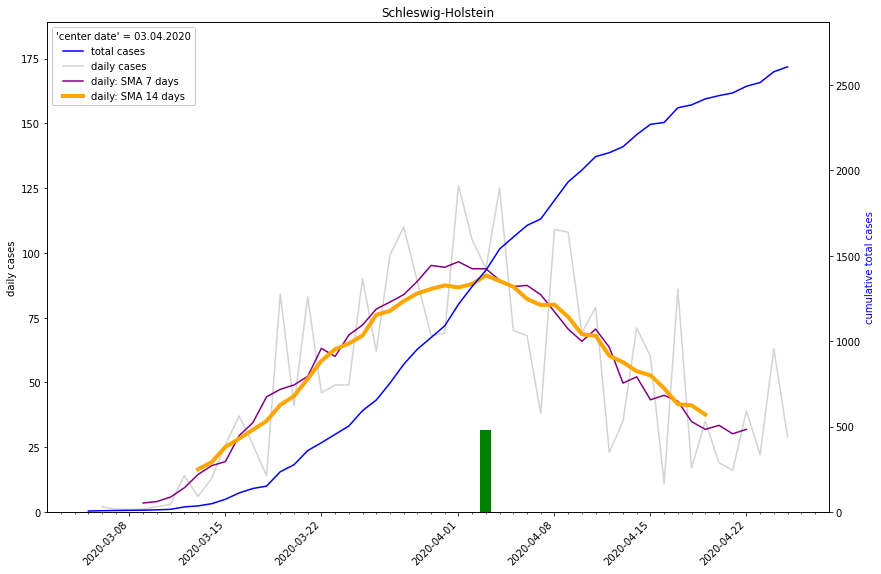

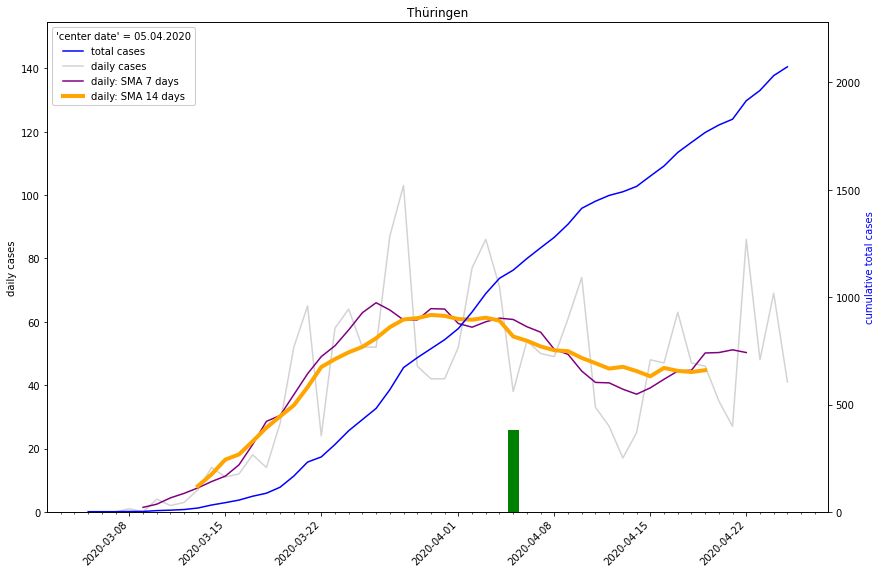

In [686]:
for BL in Bundeslaender.index.tolist():
    daily, cumulative, title, filename, population = get_BuLa(BL)
    plot_timeseries(dates, daily, cumulative, title, filename=filename)

In [687]:
ts_BuLa["centerday"] = [ temporal_center( AGS_to_ts_daily("%s" % AGS) )[0] for AGS in ts_BuLa["AGS"].tolist() ]
ts_sorted=ts_BuLa.sort_values("centerday").set_index("AGS")

In [688]:
def maxdata(ts_sorted):
    maxvalue = max(ts_sorted[ts.columns[2:]].max())
    digits=int(1+numpy.log10(maxvalue))
    return maxvalue, digits

maxdata(ts_sorted)

(5532.0, 4)

In [689]:
ts_sorted["centerday"][1001]



20.75

In [690]:
def toHTMLRow_diffmean(AGS, digits, cmap, labels):
    row = ts_sorted[ts.columns[2:]].loc[AGS].astype('int')
    diff= pandas.DataFrame(row).diff(axis=0)[AGS].tolist()
    diff[0]=0 # overwrite the nan
    diff=list(map(int, diff)) #make integer
    
    window=14
    rolling_mean_diff = pandas.DataFrame(diff).rolling(window=window, center=True).mean().fillna(0)[0].tolist()
    # return rolling_mean_diff
    
    cumulative=row.tolist()
    # return diff, cumulative
    cummax, diffmax, rollingdiffmax = max(cumulative), max(diff), max(rolling_mean_diff)
    # return cummax, diffmax, rollingdiffmax
    line="<tr>"
    # for c,d in zip(cumulative, rolling_mean_diff):
    for c,d in zip(cumulative, diff):
        rgb = matplotlib.colors.to_hex(cmap(d/rollingdiffmax))
        line+='<td bgcolor="%s">%d</td>' % (rgb, c)
    for label in labels:
        line+="<td>%s</td>" % label
    return line + "</tr>"
    
total_max_cum, digits = maxdata(ts_sorted)
cmap=plt.get_cmap("Wistia")
toHTMLRow(5370, digits, cmap, labels=["5370"])

'<tr><td bgcolor="#e4ff7a">114</td><td bgcolor="#e4ff7a">197</td><td bgcolor="#e4ff7a">214</td><td bgcolor="#e4ff7a">283</td><td bgcolor="#ffa500">300</td><td bgcolor="#ffa600">323</td><td bgcolor="#fe9400">365</td><td bgcolor="#ffa000">403</td><td bgcolor="#fd8d00">483</td><td bgcolor="#fd8c00">558</td><td bgcolor="#fd8500">589</td><td bgcolor="#fc7f00">663</td><td bgcolor="#fc7f00">690</td><td bgcolor="#fd8f00">755</td><td bgcolor="#fe9900">811</td><td bgcolor="#ffa100">890</td><td bgcolor="#ff9b00">916</td><td bgcolor="#ffa500">916</td><td bgcolor="#ffae00">964</td><td bgcolor="#ffac00">1011</td><td bgcolor="#ffb400">1043</td><td bgcolor="#ffa600">1067</td><td bgcolor="#ffa700">1153</td><td bgcolor="#ffaa00">1153</td><td bgcolor="#ffac00">1202</td><td bgcolor="#ffa000">1246</td><td bgcolor="#ffac00">1281</td><td bgcolor="#ffa600">1307</td><td bgcolor="#ffb500">1373</td><td bgcolor="#ffba00">1417</td><td bgcolor="#ffc103">1436</td><td bgcolor="#ffc404">1436</td><td bgcolor="#ffd20d">

In [732]:
def toHTMLRow(AGS, digits, cmap, labels, rolling_window_size=5):
    row = ts_sorted[ts.columns[2:]].loc[AGS].astype('int')
    # return row

    window=rolling_window_size
    rolling_mean_cum = row.rolling(window=window, center=True).mean()
    # return rolling_mean_cum

    # diff= pandas.DataFrame(rolling_mean_cum).diff(axis=0).fillna(0)[AGS].tolist()
    diff= pandas.DataFrame(rolling_mean_cum).diff(axis=0)[AGS].tolist()
    # return diff
    
    cumulative=row.tolist()
    # return diff, cumulative
    diffmax = numpy.nanmax(diff)
    # return diffmax
    line="<tr>"
    # for c,d in zip(cumulative, rolling_mean_diff):
    for c,d in zip(cumulative, diff):
        rgb = matplotlib.colors.to_hex(cmap(d/diffmax))
        line+='<td bgcolor="%s"><span>%d</span></td>' % (rgb, c)
    for label in labels:
        line+="<td>%s</td>" % label
    return line + "</tr>"
    
total_max_cum, digits = maxdata(ts_sorted)
cmap=plt.get_cmap("Wistia")
cmap.set_bad("white")
toHTMLRow(5370, digits, cmap, labels=["5370"])

'<tr><td bgcolor="#ffffff"><span>114</span></td><td bgcolor="#ffffff"><span>197</span></td><td bgcolor="#ffffff"><span>214</span></td><td bgcolor="#ffa600"><span>283</span></td><td bgcolor="#ffb600"><span>300</span></td><td bgcolor="#ffae00"><span>323</span></td><td bgcolor="#ffaa00"><span>365</span></td><td bgcolor="#fe9200"><span>403</span></td><td bgcolor="#fd8e00"><span>483</span></td><td bgcolor="#fc8000"><span>558</span></td><td bgcolor="#fd8500"><span>589</span></td><td bgcolor="#fd8b00"><span>663</span></td><td bgcolor="#fe9400"><span>690</span></td><td bgcolor="#fc7f00"><span>755</span></td><td bgcolor="#fe9400"><span>811</span></td><td bgcolor="#ffa000"><span>890</span></td><td bgcolor="#ffa600"><span>916</span></td><td bgcolor="#ffaa00"><span>916</span></td><td bgcolor="#ffbc00"><span>964</span></td><td bgcolor="#ffbd00"><span>1011</span></td><td bgcolor="#ff9b00"><span>1043</span></td><td bgcolor="#ffae00"><span>1067</span></td><td bgcolor="#ffad00"><span>1153</span></td><t

In [733]:
PAGE="""

<!DOCTYPE html>
<html>
<head>
<STYLE>

table {
  border-collapse: collapse;
}
th, td {
  text-align:center;
  font-family: 'Roboto Condensed', sans-serif;
}


td span
{
  font-family: 'Teko', sans-serif;
  text-align:center;
}


th
{
  vertical-align: bottom;
  text-align: center;
}

th span
{
  -ms-writing-mode: tb-rl;
  -webkit-writing-mode: vertical-rl;
  writing-mode: vertical-rl;
  transform: rotate(180deg);
  white-space: nowrap;
  font-family: sans-serif;
}
</STYLE>
<link href="https://fonts.googleapis.com/css?family=Roboto+Condensed|Teko&display=swap" rel="stylesheet">
</head>
<body>
"""

PAGE_END="""
</body>
</html>
"""

In [734]:
total_max_cum, digits = maxdata(ts_sorted)
cmap=plt.get_cmap("Wistia")
# cmap.set_under(), cmap.set_over() outside [0,1]
district_AGSs = [1001, 1002, 5370, 9377]
district_AGSs = ts_sorted.index.tolist()

page = PAGE + "<table><tr>\n"
for col in ts.columns[2:]:
    page += "<th><span>%s</span></th>" % col

cols = ["Kreis", "Population", "Bundesland", "center day" ]
for col in cols:
    page += "<th>%s</th>" % col
page +="</tr>"
for AGS in district_AGSs:
    gen, bez, inf, pop = AGS_to_population(AGS)
    name_BL, inf_BL, pop_BL = AGS_to_Bundesland(AGS)
    labels = ["%s (%s)" % (gen, bez)]
    labels += [pop]
    labels += [name_BL]
    labels += ["%.2f"% (ts_sorted["centerday"][AGS])]
    page += toHTMLRow(AGS, digits, cmap, labels) + "\n"
page += "</table>" + PAGE_END

fn=os.path.join(PAGES_PATH, "test.html")
with open(fn, "w") as f:
    f.write(page)
print (fn)

../data/../pages/test.html
